In [1]:
import xml.etree.ElementTree as ET 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re
import os

# Umwandlung relevanter Bestandteile der xml-Datei in DataFrame:

**Alle Bundestagsreden finden sich in xml-Format unter:**
https://www.bundestag.de/service/opendata

**Dokumentation xml-Aufbau unter:**
https://www.bundestag.de/blob/577234/f9159cee3e045cbc37dcd6de6322fcdd/dbtplenarprotokoll_kommentiert-data.pdf

### Hinweise:
Ziffernfolgen in den Redner-IDs: 
* Abgeordneten-IDs sind in der Regel 8-stellig und beginnen mit den Ziffern ‘1100‘
* IDs für alle anderen Redner sind 9-stellig und beginnen mit den Ziffern ‘9999‘

Fragerunden werden beim Parsen der xml-Dokumente aktuell ausgeklammert.

Den wesentlichen Inhalt eines Tagesordnungspunktes (TOP) gibt der Wert "T_fett" des Attributs "klasse" wieder.



In [2]:
def get_reden(xml_doc):
    col_names=['sitzung_datum','top_text','rede_id','redner_id','rede_text', 'kommentare']
    d = pd.DataFrame(columns = col_names)
    
    sitzung_datum = xml_doc.get('sitzung-datum')
    
    for top in xml_doc.findall('./sitzungsverlauf/tagesordnungspunkt'):
    
        top_text = ','.join(t.text for t in top.findall("./p[@klasse='T_fett']"))
    
        for rede in top.findall("./rede"):
            rede_id = rede.get('id')
            redner_id = rede.find('.//redner').get('id') if rede.find('.//redner').get('id') else None


            Rede_Unterbrechung = False
            rede_text = []

            for beitrag in rede:
                if beitrag.get('klasse') in ['J_1', 'J', 'O','Z'] and not Rede_Unterbrechung:
                    if beitrag.text is not None:
                        rede_text.append(beitrag.text)

                if beitrag.tag == 'name':
                    Rede_Unterbrechung = True

                if beitrag.get('klasse') == 'redner':
                    if beitrag.find('.//redner').get('id') == redner_id:
                        Rede_Unterbrechung = False
                    else:
                        Rede_Unterbrechung = True


            rede_text = ' '.join(text for text in rede_text)

            kommentare = [kommentar.text for kommentar in rede if kommentar.tag == 'kommentar']

            d = d.append(pd.DataFrame([[sitzung_datum, top_text, rede_id, redner_id, rede_text, kommentare]],
                          columns = col_names), ignore_index=True)
    return d

**Die Bundestagsreden eines Tages sind einzelnen xml-Dokumenten zu finden. Die im Rahmen der Analyse betrachteten Bundestagsreden liegen im Zeitraum von Dienstag, den 24. Oktober 2017 bis Donnerstag, den 31. Januar 2019.**

In [3]:
sitzungen = [sitzung for sitzung in os.listdir(path='Redetexte/') if sitzung.endswith('.xml')]

Alle xml-Dokumente werden geparst und in einer Liste gespeichert:

In [4]:
df = pd.DataFrame()
for sitzung in sitzungen:
    tree = ET.parse('Redetexte/'+sitzung)  
    root = tree.getroot()
    df = df.append(get_reden(root),ignore_index=True)

# Ergänzung Stammdaten der Abgeordneten

**Die Stammdaten der Abgeordnete und sonstigen Redner finden sich ebenfalls unter:**
https://www.bundestag.de/service/opendata

In [5]:
tree_speakers = ET.parse('MDB_STAMMDATEN.XML')
root_speakers = tree_speakers.getroot()

In [6]:
col_names = ['ID']
col_names += [name.tag for name in root_speakers.find(".//NAME").iterfind(".//")] 
col_names += [bio.tag for bio in root_speakers.find(".//BIOGRAFISCHE_ANGABEN").iterfind(".//")]

Erstellen einer Liste mit allen Stammdaten:

In [7]:
df_stamm = []
for speaker in root_speakers.iter('MDB'):
    new_row = [speaker.find('ID').text]
    new_row += [name.text for name in speaker.find(".//NAME").iterfind(".//")]
    new_row += [bio.text for bio in speaker.find(".//BIOGRAFISCHE_ANGABEN").iterfind(".//")]
    df_stamm.append(new_row)
df_stamm = pd.DataFrame(df_stamm, columns=col_names)

Zusammenführen der Liste mit Bundestagsreden und Stammdaten aller Redner:

In [8]:
df = df.merge(df_stamm[['ID','VORNAME','NACHNAME','PARTEI_KURZ']],how='left',left_on='redner_id', right_on='ID').drop(columns=['ID'])

In [9]:
df.head()

,sitzung_datum,top_text,rede_id,redner_id,rede_text,kommentare,VORNAME,NACHNAME,PARTEI_KURZ
0,29.06.2018,"Finanzhilfen zugunsten Griechenlands:,Vierte u...",ID194300100,999990073,Herr Präsident! Meine Damen und Herren! Griech...,"[(Beifall bei der SPD und der CDU/CSU), (Beifa...",NaN,NaN,NaN
1,29.06.2018,"Finanzhilfen zugunsten Griechenlands:,Vierte u...",ID194300200,11004675,Herr Präsident! Liebe Kolleginnen! Liebe Kolle...,"[(Beifall bei der AfD), (Beifall bei der AfD),...",Peter,Boehringer,AfD
2,29.06.2018,"Finanzhilfen zugunsten Griechenlands:,Vierte u...",ID194300300,11003826,Herr Präsident! Liebe Kolleginnen und Kollegen...,[(Beifall bei der CDU/CSU und der SPD sowie be...,Eckhardt,Rehberg,CDU
3,29.06.2018,"Finanzhilfen zugunsten Griechenlands:,Vierte u...",ID194300400,11004705,Herr Präsident! Meine sehr verehrten Kolleginn...,[(Dr. Alexander Gauland [AfD]: Als ein viertes...,Christian,Dürr,FDP
4,29.06.2018,"Finanzhilfen zugunsten Griechenlands:,Vierte u...",ID194300500,11004817,Herr Präsident! Sehr geehrte Damen und Herren!...,"[(Beifall bei der LINKEN), (Peter Boehringer [...",Fabio,De Masi,DIE LINKE.


Je Redner wird noch die Anzahl der im Bundestag gehaltenen Reden ergänzt:

In [10]:
reden = df['redner_id'].value_counts().reset_index().rename(columns = {'index':'redner_id', 'redner_id':'anzahl_reden'})

In [11]:
df = pd.merge(df,reden,'left','redner_id')

# Bereinigung der Redetexte

In [12]:
def clean_redetext(text, split=True, lower=True ):
    text =(text
            .replace('ğ','g')
            .replace('š','s')
            .replace('ʼ',' ')
            .replace('ı','l')
            .replace('ę','e')
            .replace('œ','oe')
            .replace('ş','s')
            .replace('ć','c')
            .replace('ǎ','a')
            .replace('ă','a')
            .replace('ȇ','e')
            )
    if lower:
        text = text.lower()
    if split:
        text = re.findall('(\w+-\w+|\w+|\d+)', text)
    else:
        text = ' '.join(re.findall('(\w+-\w+|\w+|\d+)', text))
    return(text)

# Bewertung der sprachlichen Diversität

Es werden für jede die Anzahl der eindeutigen Wörter sowie der Wörter insgesamt gezählt. Die Diversität ist der Quotient aus Anzahl Wörter eindeutig und Anzahl Wörter insgesamt.

In [13]:
color_palette_dic = {'FDP':'yellow', 'SPD':'r', 'AfD':'royalblue', 'DIE LINKE.': 'magenta', 'CDU':'k',
                     'BÜNDNIS 90/DIE GRÜNEN': 'g', 'CSU':'k', 'Blaue':'b', 'Plos':'grey'}

In [14]:
df['rede_woerter'] = df['rede_text'].apply(lambda x: len(clean_redetext(x)))

In [15]:
#ax = sns.catplot(x="PARTEI_KURZ", y="rede_woerter", data=df, aspect=3, palette=color_palette_dic)

In [16]:
df['rede_woerter_eindeutig'] = df['rede_text'].apply(lambda x: len(set(clean_redetext(x))))

In [17]:
#ax = sns.catplot(x="PARTEI_KURZ", y="rede_woerter_eindeutig", data=df, aspect=3, palette=color_palette_dic)

In [18]:
df['diversität'] = df.rede_woerter_eindeutig/df.rede_woerter

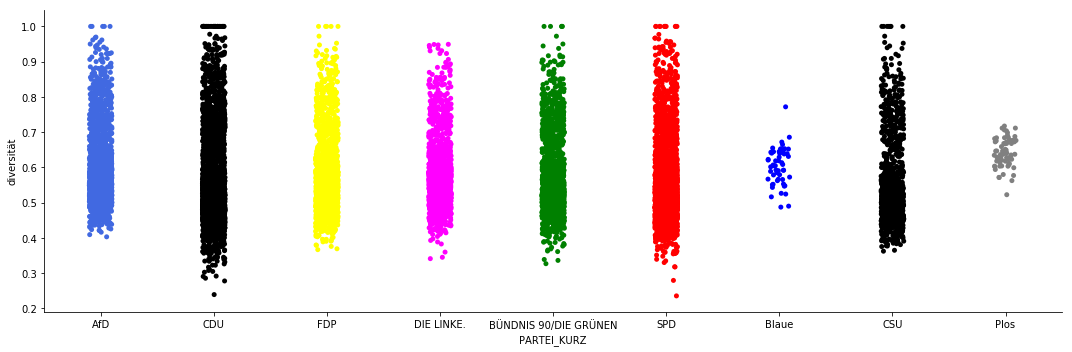

In [19]:
ax = sns.catplot(x="PARTEI_KURZ", y="diversität", data=df, aspect=3, palette=color_palette_dic)

**Berechnung der Diversität für jeden einzelnen Redner mit mehr als 5 Reden im betrachteten Zeitraum:**

In [20]:
flop_diversitaet= (
    df[df.anzahl_reden>5]
    .drop(columns=['rede_woerter','rede_woerter_eindeutig'])
    .groupby(['redner_id','VORNAME','NACHNAME','PARTEI_KURZ'])
    .mean()
    .sort_values('diversität')
)
flop_diversitaet.head(20)

,,,,anzahl_reden,diversität
redner_id,VORNAME,NACHNAME,PARTEI_KURZ,,
11004021,Ralph,Brinkhaus,CDU,17,0.355350
11003196,Andrea,Nahles,SPD,15,0.421017
11003516,Alexander,Dobrindt,CSU,19,0.437609
11004770,Ingmar,Jung,CDU,17,0.438632
11004116,Nadine,Müller,CDU,24,0.441427
11004083,Rüdiger,Kruse,CDU,14,0.441882
11003034,Dietmar,Bartsch,DIE LINKE.,21,0.442343
11003861,Marcus,Weinberg,CDU,24,0.442642
11004285,Fritz,Güntzler,CDU,20,0.446031


In [21]:
top_diversitaet= (
    df[df.anzahl_reden>5]
    .drop(columns=['rede_woerter','rede_woerter_eindeutig'])
    .groupby(['redner_id','VORNAME','NACHNAME','PARTEI_KURZ'])
    .mean()
    .sort_values('diversität', ascending=False)
)
top_diversitaet.head(20)

,,,,anzahl_reden,diversität
redner_id,VORNAME,NACHNAME,PARTEI_KURZ,,
11003510,Helge,Braun,CDU,38,0.779843
11003870,Brigitte,Zypries,SPD,21,0.728209
11002742,Gerd,Müller,CSU,49,0.724159
11001478,Angela,Merkel,CDU,207,0.720808
11004769,Christian,Jung,FDP,15,0.716036
11002672,Barbara,Hendricks,SPD,40,0.710213
11002140,Horst,Seehofer,CSU,42,0.707578
11004850,Tobias Matthias,Peterka,AfD,23,0.706866
11004690,Karlheinz,Busen,FDP,13,0.695636


# Wer hat die meisten Wiederholungen in einer Rede?

Die Idee besteht darin, dass Redetexte komprimiert werden - in Anlehnung an die Komprimierung von z.B. Textdokumenten in zip-Dateien. Je häufiger sich einzelne Wörter oder Wortabfolgen in einer Rede finden, desto stärker kann der Redetext auch komprimiert werden und desto repetitiver ist dieser. Ein Kompressionswert von 30% bedeutet, dass der ursprüngliche Redetext auf 30% komprimiert werden kann.

https://de.wikipedia.org/wiki/Lempel-Ziv-Welch-Algorithmus

Code übernommen von https://rosettacode.org/wiki/LZW_compression#Python

In [22]:
def compress(uncompressed):
    """Compress a string to a list of output symbols."""
    

    # Build the dictionary.
    dict_size = 256
    dictionary = {chr(i): i for i in range(dict_size)}
 
    w = ""
    result = []
    for c in uncompressed:
        wc = w + c
        if wc in dictionary:
            w = wc
        else:
            result.append(dictionary[w])
            # Add wc to the dictionary.
            dictionary[wc] = dict_size
            dict_size += 1
            w = c
 
    # Output the code for w.
    if w:
        result.append(dictionary[w])
    return len(result)/len(uncompressed)

In [23]:
df['kompression'] = df.loc[df.rede_text!="",'rede_text'].apply(lambda x: (compress(clean_redetext(x,split=False))))

**Die Kompression wird ins Verhältnis zur Anzahl der Wörter in einer Rede um einen besseren Vergleich des Kompressionswertes bei unterschiedlich langen Reden zu erleichtern:**

In [24]:
df['kompression_normalisiert'] = df.kompression/df.rede_woerter

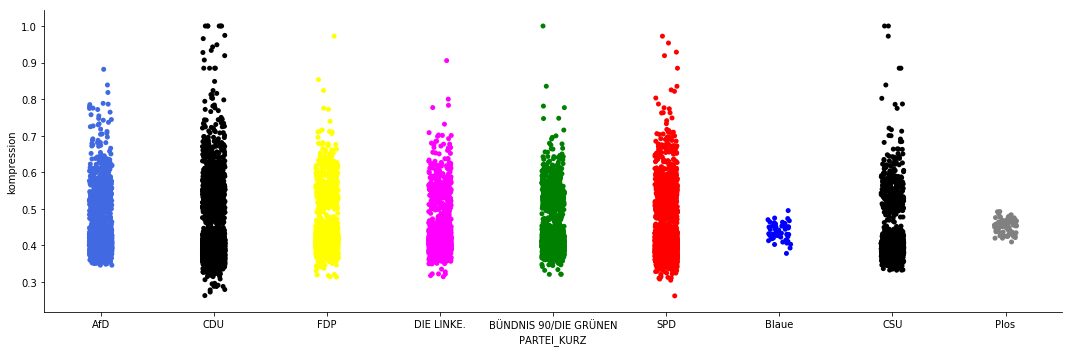

In [25]:
ax = sns.catplot(x="PARTEI_KURZ", y="kompression", data=df, aspect=3, palette=color_palette_dic)

**Die Kompression von Reden lässt sich wieder für jeden einzelnen Redner mit mehr als 5 Bundestagsreden betrachten:**

In [26]:
flop_kompression= (
    df[df.anzahl_reden>5]
    .drop(columns=['rede_woerter','rede_woerter_eindeutig'])
    .groupby(['redner_id','VORNAME','NACHNAME','PARTEI_KURZ'])
    .mean()
    .sort_values('kompression_normalisiert')
    .head(20)
)
flop_kompression

,,,,anzahl_reden,diversität,kompression,kompression_normalisiert
redner_id,VORNAME,NACHNAME,PARTEI_KURZ,,,,
11004021,Ralph,Brinkhaus,CDU,17,0.355350,0.335257,0.000231
11003196,Andrea,Nahles,SPD,15,0.421017,0.348828,0.000302
11004183,Sahra,Wagenknecht,DIE LINKE.,9,0.472106,0.364223,0.000342
11003034,Dietmar,Bartsch,DIE LINKE.,21,0.442343,0.363656,0.000345
11004108,Andreas,Mattfeldt,CDU,8,0.457469,0.371436,0.000392
11004285,Fritz,Güntzler,CDU,20,0.446031,0.369408,0.000410
11003614,Sascha,Raabe,SPD,15,0.459218,0.376206,0.000424
11004083,Rüdiger,Kruse,CDU,14,0.441882,0.376165,0.000431
11003630,Swen,Schulz,SPD,6,0.478080,0.375897,0.000431


In [27]:
top_kompression= (
    df[df.anzahl_reden>5]
    .drop(columns=['rede_woerter','rede_woerter_eindeutig'])
    .groupby(['redner_id','VORNAME','NACHNAME','PARTEI_KURZ'])
    .mean()
    .sort_values('kompression_normalisiert',ascending=False)
    .head(20)
)
top_kompression

,,,,anzahl_reden,diversität,kompression,kompression_normalisiert
redner_id,VORNAME,NACHNAME,PARTEI_KURZ,,,,
11001938,Wolfgang,Schäuble,CDU,7,0.674699,0.562901,0.050545
11002140,Horst,Seehofer,CSU,42,0.707578,0.545890,0.029427
11002742,Gerd,Müller,CSU,49,0.724159,0.550666,0.027487
11001235,Wolfgang,Kubicki,FDP,7,0.591000,0.500119,0.020794
11004323,Anja,Karliczek,CDU,118,0.694619,0.541036,0.018299
11003510,Helge,Braun,CDU,38,0.779843,0.599588,0.016183
11002617,Peter,Altmaier,CDU,96,0.657145,0.497509,0.014977
11001478,Angela,Merkel,CDU,207,0.720808,0.554202,0.014341
11003744,Martin,Burkert,SPD,8,0.632481,0.471237,0.011351


# Wie wird im Bundestag gesprochen: Von Schwarzmalern und Optimisten

Ob eine Rede optimistisch oder pessimistisch bzw. eher postive oder negative Gefühle vermittelt, lässt sich ebenfalls untersuchen ("Sentiment Analysis"). Dazu bedient man sich eines Wörterbuchs, welches für jedes Wort festlegt, ob mit dessen Verwendung eine positive oder negative Wahrnehmung verbunden ist. Das Wort "schlecht" hat beispielsweise eine negative Bedeutung, das Wort "exzellent" eine positive Bedeutung. Positiven sowie negativen Worten kann ein numerischer Wert zugeordnet werden. Für negative Wörter ist dieser kleiner 1 für positive größer 1.

**Bewertung von Wörtern bzgl. positiver und negativer Wahrnehmung durch Experten:**
https://www.kaggle.com/rtatman/german-sentiment-analysis-toolkit/home

In [28]:
positiv = pd.read_csv('SentiWS_v1.8c_Positive.txt',sep='\t', lineterminator='\n', header=None, names=['stamm','sentiment','varianten'])

In [29]:
negativ = pd.read_csv('SentiWS_v1.8c_Negative.txt',sep='\t', lineterminator='\n', header=None, names=['stamm','sentiment','varianten'])

**Positive Wörter:**

In [30]:
positiv = pd.concat([positiv, positiv.stamm.str.split(pat='|',expand=True)],axis=1)
positiv = positiv.rename(index=str, columns={0: "wort", 1: "wortart"})
positiv = positiv.drop('stamm',axis=1)
positiv.varianten = positiv.varianten.str.split(',').fillna('')
positiv.head()

,sentiment,varianten,wort,wortart
0,0.004,[Abmachungen],Abmachung,NN
1,0.004,"[Abschlüße, Abschlußs, Abschlußes, Abschlüßen]",Abschluß,NN
2,0.004,[Abstimmungen],Abstimmung,NN
3,0.004,,Agilität,NN
4,0.004,[Aktivitäten],Aktivität,NN


**Negative Wörter:**

In [31]:
negativ = pd.concat([negativ, negativ.stamm.str.split(pat='|',expand=True)],axis=1)
negativ = negativ.rename(index=str, columns={0: "wort", 1: "wortart"})
negativ = negativ.drop('stamm',axis=1)
negativ.varianten = negativ.varianten.str.split(',').fillna('')
negativ.head()

,sentiment,varianten,wort,wortart
0,-0.0580,"[Abbaus, Abbaues, Abbauen, Abbaue]",Abbau,NN
1,-0.0048,"[Abbruches, Abbrüche, Abbruchs, Abbrüchen]",Abbruch,NN
2,-0.0048,[Abdankungen],Abdankung,NN
3,-0.0048,[Abdämpfungen],Abdämpfung,NN
4,-0.0048,"[Abfalles, Abfälle, Abfalls, Abfällen]",Abfall,NN


In [32]:
x_pos = {key.lower(): positiv.loc[positiv.wort==key,'sentiment'].item() for key in positiv.wort}

In [33]:
x_neg = {key.lower(): negativ.loc[negativ.wort==key,'sentiment'].item() for key in negativ.wort}

In [34]:
y_pos = {wort.lower(): positiv.iloc[i,0].item() for i in range(positiv.shape[0]) for wort in positiv.iloc[i,1]}

In [35]:
y_neg = {wort.lower(): negativ.iloc[i,0].item() for i in range(negativ.shape[0]) for wort in negativ.iloc[i,1]}

In [36]:
sentiment_dict = {**x_pos,**x_neg,**y_pos,**y_neg}

**Bewertung der Reden:**

Verständnis 'Sentiment': Wert >0 --> Positive Rede, Wert <0 --> Negative Rede

In [37]:
df['sentiment'] = df['rede_text'].apply(lambda x: np.sum([sentiment_dict[wort] for wort in clean_redetext(x) if wort in sentiment_dict.keys()]))

**Betrachtung je Partei** (Überraschung, die Regierungsparteien reden eher positiv ;-))

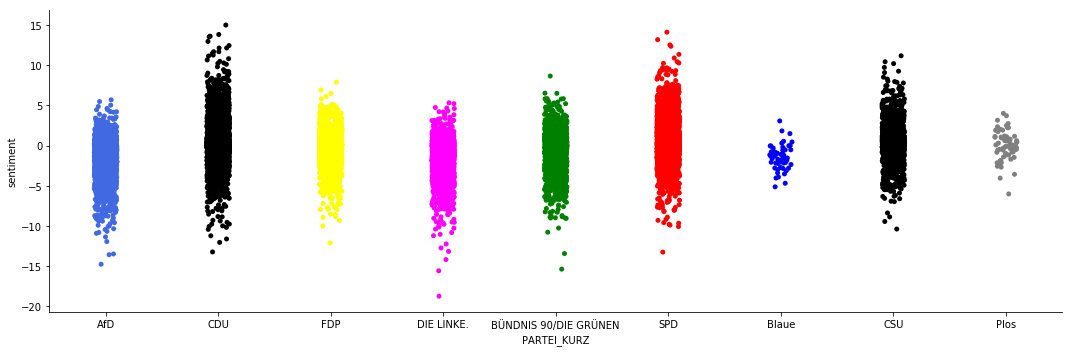

In [38]:
ax = sns.catplot(x="PARTEI_KURZ", y="sentiment", data=df, aspect=3, palette=color_palette_dic)

**Betrachtung je Render:**

In [39]:
top_negativ= (
    df[df.anzahl_reden>5]
    .drop(columns=['rede_woerter','rede_woerter_eindeutig','diversität','kompression'])
    .groupby(['redner_id','VORNAME','NACHNAME','PARTEI_KURZ'])
    .mean()
    .sort_values('sentiment')
)
top_negativ.head(10)

,,,,anzahl_reden,kompression_normalisiert,sentiment
redner_id,VORNAME,NACHNAME,PARTEI_KURZ,,,
11004930,Alice,Weidel,AfD,15,0.000438,-5.858887
11004183,Sahra,Wagenknecht,DIE LINKE.,9,0.000342,-5.705889
11003034,Dietmar,Bartsch,DIE LINKE.,21,0.000345,-5.498362
11004385,Martina,Renner,DIE LINKE.,8,0.000889,-3.546488
11004749,Martin,Hess,AfD,35,0.002454,-3.520557
11004070,Sven-Christian,Kindler,BÜNDNIS 90/DIE GRÜNEN,28,0.000673,-3.457543
11004698,Gottfried,Curio,AfD,44,0.002215,-3.454416
11004736,Mariana Iris,Harder-Kühnel,AfD,12,0.004336,-3.439250
11004679,Michel,Brandt,DIE LINKE.,9,0.000767,-3.424778


In [40]:
top_positiv= (
    df[df.anzahl_reden>5]
    .drop(columns=['rede_woerter','rede_woerter_eindeutig','diversität', 'kompression'])
    .groupby(['redner_id','VORNAME','NACHNAME','PARTEI_KURZ'])
    .mean()
    .sort_values('sentiment',ascending=False)
)
top_positiv.head(10)

,,,,anzahl_reden,kompression_normalisiert,sentiment
redner_id,VORNAME,NACHNAME,PARTEI_KURZ,,,
11003734,Thomas,Bareiß,CDU,7,0.000979,6.180100
11003630,Swen,Schulz,SPD,6,0.000431,5.587667
11003758,Martin,Gerster,SPD,8,0.000508,5.330300
11004382,Kerstin,Radomski,CDU,6,0.000501,4.964533
11004251,Sybille,Benning,CDU,6,0.000474,4.473417
11003582,Patricia,Lips,CDU,7,0.000572,3.574029
11003896,Eva,Högl,SPD,29,0.001111,3.540045
11004173,Kerstin,Tack,SPD,22,0.002100,3.489655
11004334,Roy,Kühne,CDU,9,0.002199,3.383489


# Grafische Aufbereitung

In [41]:
d = (
    df
    .groupby(['redner_id','VORNAME','NACHNAME','PARTEI_KURZ'])
    .mean()
    .reset_index()
)

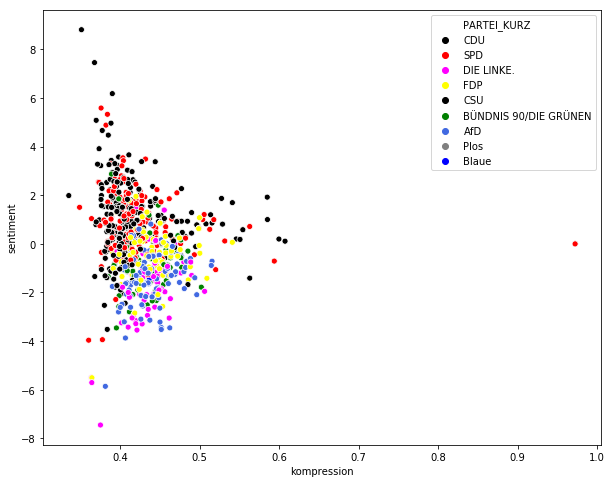

In [42]:
f, ax = plt.subplots(figsize=(10,8))
ax = sns.scatterplot(ax=ax, x="kompression", y="sentiment", data=d, hue = "PARTEI_KURZ", palette=color_palette_dic)

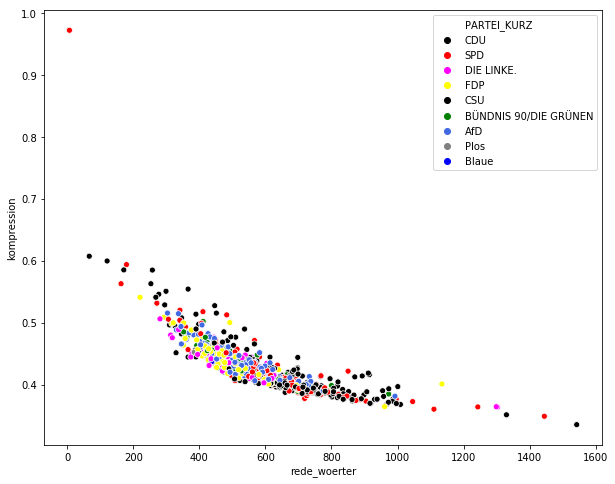

In [43]:
f, ax = plt.subplots(figsize=(10,8))
ax = sns.scatterplot(ax=ax, x="rede_woerter", y="kompression", data=d, hue = "PARTEI_KURZ", palette=color_palette_dic)

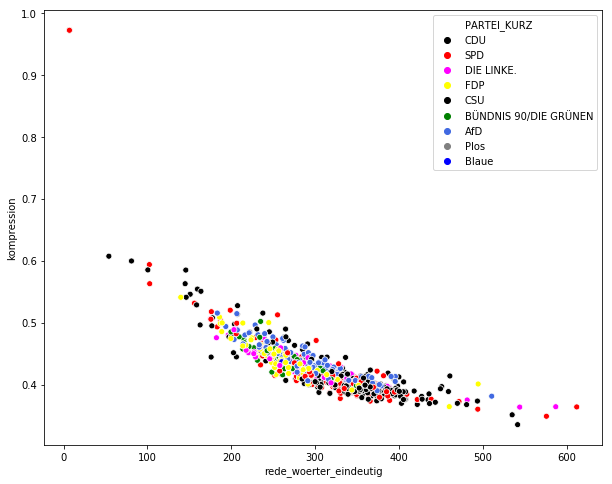

In [44]:
f, ax = plt.subplots(figsize=(10,8))
ax = sns.scatterplot(x="rede_woerter_eindeutig", y="kompression", data=d, hue = "PARTEI_KURZ", palette=color_palette_dic)

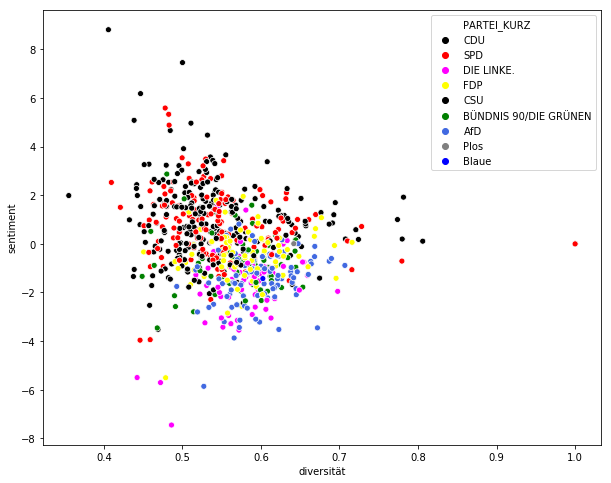

In [45]:
f, ax = plt.subplots(figsize=(10,8))
ax = sns.scatterplot(x="diversität", y="sentiment", data=d, hue = "PARTEI_KURZ", palette=color_palette_dic)

# Was sind (un-) typische Wörter der Parteien

Für jede Partei werden deren (un-)typische Wörter berechnet. Für die Ermittlung berechnet man die Anzahl der Wörter, die in Reden einer Partei zu finden sind und teilt diese durch die Anzahl eben dieser Wörter in den Reden aller anderen Fraktionen. Für eine bessere Darstellung nimmt man zusätzlich noch den Logarithmus diese Quotienten.

In [46]:
def partei_woerter(df, partei, min_woerter=5, anzahl_woerter=20):
    fdist1 = nltk.FreqDist([item for sublist in df.loc[df.PARTEI_KURZ==partei,'rede_text'].apply(lambda x: clean_redetext(x)) for item in sublist])
    fdist2 = nltk.FreqDist([item for sublist in df.loc[df.PARTEI_KURZ!=partei,'rede_text'].apply(lambda x: clean_redetext(x)) for item in sublist])
    word_dic = {key:np.log(fdist1[key]/fdist2[key]) for key in fdist1.keys() if fdist2[key]!=0 and fdist1[key]>min_woerter}
    return(pd.concat([
        pd.DataFrame(sorted(word_dic.items(), key= lambda x:x[1],reverse=True)[1:anzahl_woerter],columns=['wort','indexwert-typisch']),
        pd.DataFrame(sorted(word_dic.items(), key= lambda x:x[1],reverse=False)[1:anzahl_woerter],columns=['wort','indexwert-untypisch'])],
                    axis=1)
          )

In [47]:
partei_woerter(df,'AfD')

,wort,indexwert-typisch,wort,indexwert-untypisch
0,klimareligion,2.484907,spd-fraktion,-4.048882
1,links-grüne,2.484907,schwierigen,-3.955508
2,links-grün,2.397895,faire,-3.825531
3,ungläubigen,2.397895,finde,-3.787295
4,hypothese,2.302585,verständigt,-3.776585
5,importquote,2.302585,emissionshandel,-3.749504
6,raffelhüschen,2.302585,baukindergeld,-3.716616
7,ehrenmorde,2.302585,zusammenarbeiten,-3.698211
8,fernsehbildschirmen,2.197225,bürgerinnen,-3.650923
9,wirtschaftsmigranten,2.197225,demokraten,-3.609279


In [48]:
partei_woerter(df,'CSU')

,wort,indexwert-typisch,wort,indexwert-untypisch
0,mig,1.945910,erdogan,-4.045971
1,unionspolitik,1.791759,abgeordnete,-3.985008
2,hochmoselbrücke,1.791759,merkel,-3.975826
3,hinzurechnungen,1.386294,endlich,-3.923073
4,wehrtechnischen,1.252763,spd-fraktion,-3.891820
5,wsb-kommission,1.252763,schweigen,-3.850148
6,aufenthaltsbeendigung,1.252763,wirtschaftsminister,-3.765069
7,christkind,1.252763,offenbar,-3.731699
8,föderalistisch,1.098612,mieterinnen,-3.710858
9,objektsteuer,0.980829,hetze,-3.688879


In [49]:
partei_woerter(df,'CDU')

,wort,indexwert-typisch,wort,indexwert-untypisch
0,wahlprüfung,2.302585,autoindustrie,-3.390024
1,reziprozität,2.197225,spd-bundestagsfraktion,-3.373027
2,euratom-vertrag,2.197225,fehlanzeige,-3.153956
3,wahlprüfungsausschusses,2.197225,altparteien,-3.153956
4,forschungsorganisationen,2.197225,überweisung,-3.068053
5,heinsberg,2.197225,demokraten,-3.024621
6,pränatale,2.197225,geflüchteten,-2.980619
7,warnhinweis,2.197225,willy,-2.974071
8,ausbildungsordnungen,2.079442,konzerne,-2.973614
9,listenmandate,2.079442,sozialdemokraten,-2.951432


In [50]:
partei_woerter(df,'DIE LINKE.')

,wort,indexwert-typisch,wort,indexwert-untypisch
0,julian,2.708050,lieben,-3.923073
1,militärhaushalt,2.639057,voranbringen,-3.825012
2,seenotretterinnen,2.639057,progression,-3.806662
3,schäfereien,2.564949,csu-fraktion,-3.793883
4,betriebsrätin,2.564949,fähigkeiten,-3.787970
5,regime-change,2.484907,demokraten,-3.777675
6,friedensgebot,2.302585,schwierigen,-3.750573
7,klimagerechtigkeit,2.302585,stärke,-3.695997
8,griechenland-hilfe,2.197225,weiterentwickeln,-3.688879
9,rüstungsschmieden,2.197225,verlässlichkeit,-3.646320


In [51]:
partei_woerter(df,'SPD')

,wort,indexwert-typisch,wort,indexwert-untypisch
0,sozialdemokratinnen,2.624669,klimakrise,-3.615412
1,morgen-gesetz,2.442347,bauern,-3.358638
2,entwicklungspolitiker,2.397895,hartz-iv,-3.202746
3,ostfriesland,2.322388,merkel,-3.148001
4,sozialstaatspapier,2.302585,eigenverantwortung,-3.120895
5,bundespolizistinnen,2.079442,überweisung,-3.068053
6,eeg-vergütung,2.079442,weiter-so,-3.052428
7,nordostsyrien,2.079442,iv,-3.031450
8,außenrat,2.079442,altparteien,-3.014309
9,bahnsteigkante,1.945910,hartz,-2.995732


In [52]:
partei_woerter(df,'FDP')

,wort,indexwert-typisch,wort,indexwert-untypisch
0,lerndaten,2.079442,verständigt,-3.618610
1,reformbemühungen,1.945910,terror,-3.569533
2,schriftführerinnen,1.945910,illegale,-3.540959
3,familienpflegezeitgesetz,1.945910,mieterinnen,-3.504738
4,hinterbliebenenrente,1.945910,erneuerbaren,-3.485280
5,lohnstückkosten,1.791759,tribünen,-3.470190
6,effizienzreserven,1.791759,dankeschön,-3.452253
7,informantenschutz,1.791759,essen,-3.433987
8,paternalismus,1.791759,gleichstellung,-3.428596
9,kostengünstigsten,1.386294,mikrogramm,-3.361532


In [53]:
partei_woerter(df,'BÜNDNIS 90/DIE GRÜNEN')

,wort,indexwert-typisch,wort,indexwert-untypisch
0,ausbildungsgarantie,2.197225,linke,-3.836285
1,garantiesicherung,2.079442,verehrten,-3.818748
2,wohnungsgemeinnützigkeit,2.079442,sozialstaat,-3.816491
3,kinderregelsätze,1.945910,vermieter,-3.733693
4,hinweisgeberschutz,1.945910,benötigen,-3.716278
5,gruppenklage,1.791759,solidaritätszuschlag,-3.680511
6,bundesinvestitionsfonds,1.791759,zuschauer,-3.666762
7,arbeitsverbote,1.791759,grunde,-3.626561
8,syndrom,1.791759,dankeschön,-3.610918
9,fehlversorgung,1.791759,vorschriften,-3.595353


# Reden und Corona 

In [92]:
df.sitzung_datum = pd.to_datetime(df.sitzung_datum, format='%d.%m.%Y')
df.query("sitzung_datum >='01.01.2020'",inplace=True)

In [54]:
df['rede_text_cleaned'] = df['rede_text'].apply(lambda x: clean_redetext(x,split=False))
df_corona = df[df.rede_text_cleaned.str.contains('sars-cov-2|covid-19|covid|corona|coronavirus|coronaviren',na=False)]

In [55]:
partei_woerter(df_corona,'AfD')

,wort,indexwert-typisch,wort,indexwert-untypisch
0,telearbeit,1.252763,deswegen,-3.075775
1,shutdown,1.098612,möchte,-2.871680
2,kurzarbeiter,0.847298,letzten,-2.833213
3,februar,0.693147,europa,-2.737903
4,spät,0.693147,gehen,-2.650892
5,notlage,0.693147,situation,-2.639057
6,ziele,0.559616,bin,-2.564949
7,afghanistan,0.405465,klar,-2.555287
8,stattdessen,0.000000,darauf,-2.555287
9,werte,0.000000,liebe,-2.546684


In [56]:
partei_woerter(df_corona,'CSU')

,wort,indexwert-typisch,wort,indexwert-untypisch
0,luftverkehrswirtschaft,1.252763,bundesregierung,-3.285198
1,absatz,1.098612,deshalb,-3.080890
2,bundesgesundheitsminister,0.847298,frau,-3.002850
3,erleichtern,0.693147,wollen,-2.984127
4,verbesserungen,0.405465,liebe,-2.917771
5,vergangenheit,0.167054,beispiel,-2.917771
6,alleine,-0.154151,ihnen,-2.884180
7,werde,-0.241162,möchte,-2.871680
8,bayern,-0.287682,nichts,-2.813411
9,wissenschaft,-0.405465,mir,-2.813411


In [57]:
partei_woerter(df_corona,'CDU')

,wort,indexwert-typisch,wort,indexwert-untypisch
0,verbraucher,2.079442,afd,-2.351375
1,überzeugung,1.945910,darf,-2.344549
2,umstand,1.791759,regierung,-2.174752
3,gleiche,1.791759,kurzarbeitergeld,-2.114533
4,wandel,1.540445,staat,-2.079442
5,ambulanten,1.504077,fdp,-2.036882
6,entscheidende,1.252763,doch,-1.987874
7,hoffnung,1.252763,kurzarbeit,-1.960095
8,ressourcen,1.252763,coronakrise,-1.902985
9,unsicherheit,1.098612,eu,-1.882731


In [58]:
partei_woerter(df_corona,'DIE LINKE.')

,wort,indexwert-typisch,wort,indexwert-untypisch
0,schwierigkeiten,0.000000,wo,-2.970414
1,mieterinnen,-0.287682,deswegen,-2.965273
2,2019,-0.287682,alles,-2.959365
3,arbeitslosengeld,-0.318454,wir,-2.957194
4,bekommt,-0.451985,also,-2.944439
5,mieter,-0.510826,wichtig,-2.937838
6,forderungen,-0.606136,lassen,-2.935628
7,esm,-0.606136,über,-2.917771
8,medien,-0.606136,arbeiten,-2.899588
9,schulen,-0.773190,allen,-2.876386


In [59]:
partei_woerter(df_corona,'SPD')

,wort,indexwert-typisch,wort,indexwert-untypisch
0,sozialdemokraten,1.252763,gesellschaft,-2.285778
1,humanitäre,1.252763,deutsche,-2.268684
2,sitzen,1.098612,gemeinsam,-2.209495
3,aufträge,1.098612,ohne,-2.184802
4,irakischen,0.847298,waren,-2.181224
5,engagement,0.810930,kinder,-2.178532
6,mitarbeitern,0.559616,notwendig,-2.131627
7,organisieren,0.470004,warum,-2.120264
8,zwingend,0.405465,drei,-2.120264
9,ungefähr,0.405465,selbst,-2.120264


In [60]:
partei_woerter(df_corona,'FDP')

,wort,indexwert-typisch,wort,indexwert-untypisch
0,freien,0.875469,viel,-3.020425
1,null,0.154151,ganz,-2.988010
2,fehlen,-0.117783,sehr,-2.944439
3,freie,-0.223144,unsere,-2.890372
4,altmaier,-0.287682,natürlich,-2.879198
5,freiheit,-0.318454,darauf,-2.862201
6,unternehmer,-0.510826,kann,-2.829940
7,libyen,-0.510826,wissen,-2.806722
8,mittelstand,-0.510826,aus,-2.782539
9,öffnung,-0.538997,prozent,-2.754570


In [61]:
partei_woerter(df_corona,'BÜNDNIS 90/DIE GRÜNEN')

,wort,indexwert-typisch,wort,indexwert-untypisch
0,infektionsschutz,1.098612,bis,-2.978925
1,anleihen,0.847298,europäischen,-2.842970
2,infektionskrankheiten,0.693147,euro,-2.803360
3,arbeitslosenversicherung,0.510826,kommen,-2.782952
4,selbstständige,0.287682,worden,-2.782952
5,ezb,0.000000,sehen,-2.762117
6,kindern,-0.117783,habe,-2.754570
7,groß,-0.133531,er,-2.740840
8,ehrlich,-0.318454,weg,-2.719100
9,gemeinsame,-0.344840,nämlich,-2.685577


## Nennung "Corona" in Reden

In [149]:
corona = [word.lower() for word in ['SARS-COV-2','COVID-19','COVID','corona','Coronavirus','Coronaviren','virus',
                                    'pandemie','epidemie'
                                   ]]

In [150]:
df['covid'] = df.rede_text.apply(lambda x: sum(clean_redetext(x,split=False).count(word) for word in corona))

In [151]:
d= (df.groupby(['sitzung_datum'])
    .agg({'covid':'sum'})
    .reset_index()
    .query('covid>0')
   )

[]

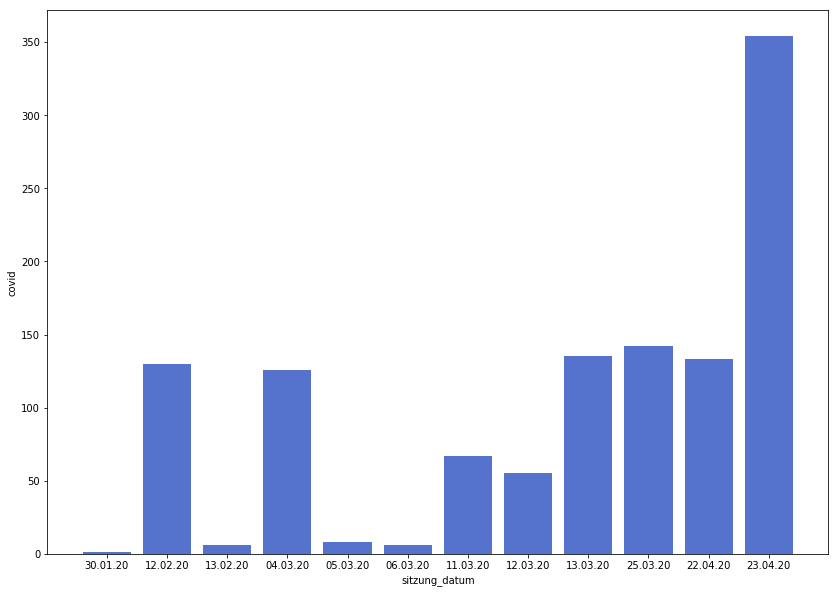

In [152]:
f, ax = plt.subplots(figsize=(14,10))
ax = sns.barplot(ax=ax, x="sitzung_datum", y="covid", data=d, color='royalblue' )
ax.set_xticklabels(d.sitzung_datum.dt.strftime('%d.%m.%y'))
ax.plot()

In [158]:
df.query("covid > 0 and sitzung_datum == '2020-02-12'")['top_text'].values

array(['Aktuelle Stunde,Strategie zur Vorbeugung gegen das Coronavirus in Deutschland',
       'Aktuelle Stunde,Strategie zur Vorbeugung gegen das Coronavirus in Deutschland',
       'Aktuelle Stunde,Strategie zur Vorbeugung gegen das Coronavirus in Deutschland',
       'Aktuelle Stunde,Strategie zur Vorbeugung gegen das Coronavirus in Deutschland',
       'Aktuelle Stunde,Strategie zur Vorbeugung gegen das Coronavirus in Deutschland',
       'Aktuelle Stunde,Strategie zur Vorbeugung gegen das Coronavirus in Deutschland',
       'Aktuelle Stunde,Strategie zur Vorbeugung gegen das Coronavirus in Deutschland',
       'Aktuelle Stunde,Strategie zur Vorbeugung gegen das Coronavirus in Deutschland',
       'Aktuelle Stunde,Strategie zur Vorbeugung gegen das Coronavirus in Deutschland',
       'Aktuelle Stunde,Strategie zur Vorbeugung gegen das Coronavirus in Deutschland',
       'Aktuelle Stunde,Strategie zur Vorbeugung gegen das Coronavirus in Deutschland',
       'Aktuelle Stunde,Strategi

In [159]:
d= (df.groupby(['sitzung_datum','PARTEI_KURZ'])
    .agg({'covid':'sum'})
    .reset_index()
    .query('covid>0')
   )

[]

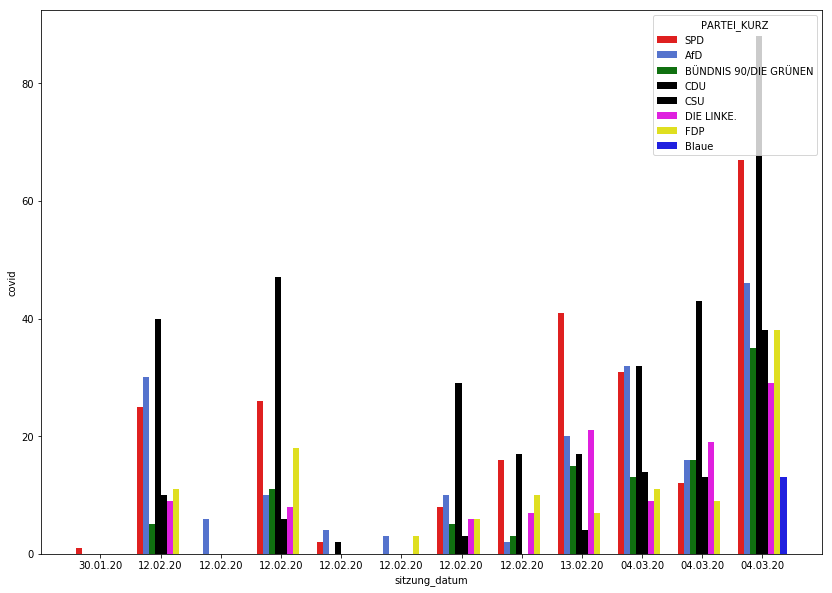

In [160]:
f, ax = plt.subplots(figsize=(14,10))
ax = sns.barplot(ax=ax, x="sitzung_datum", y="covid", data=d, hue = "PARTEI_KURZ", palette=color_palette_dic)
ax.set_xticklabels(d.sitzung_datum.dt.strftime('%d.%m.%y'))
ax.plot()

## Nennung "Maske" in Reden

In [161]:
maske = [word.lower() for word in ['Maske','Masken','Maskenpflicht','Mundschutz','Corona-Maske','Corona-Masken',
                                   'Coronamaske','Coronamaske','Schutzmaske','Schutzmasken', 'FFP-Masken', 'FFP-Maske',
                                   'Halbmaske','Halbmasken','Mund-Nasen-Schutzmaske','Mund-Nasen-Schutzmasken',
                                   
                                  ]]

In [162]:
df['maske'] = df.rede_text.apply(lambda x: sum(clean_redetext(x,split=False).count(word) for word in maske))

In [163]:
d= (df.groupby(['sitzung_datum'])
    .agg({'maske':'sum'})
    .reset_index()
    .query('maske>0')
   )

[]

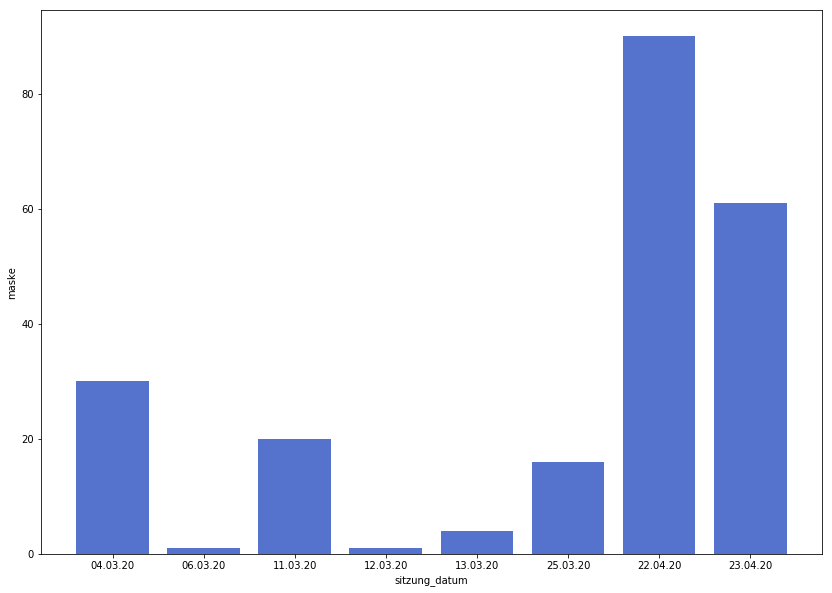

In [164]:
f, ax = plt.subplots(figsize=(14,10))
ax = sns.barplot(ax=ax, x="sitzung_datum", y="maske", data=d, color='royalblue' )
ax.set_xticklabels(d.sitzung_datum.dt.strftime('%d.%m.%y'))
ax.plot()

In [167]:
df.query("maske > 0 and sitzung_datum == '2020-03-04'")['top_text'].values

array(['Bekämpfung des Coronavirus (SARS-CoV-2) in Deutschland',
       'Bekämpfung des Coronavirus (SARS-CoV-2) in Deutschland',
       'Bekämpfung des Coronavirus (SARS-CoV-2) in Deutschland',
       'Bekämpfung des Coronavirus (SARS-CoV-2) in Deutschland',
       'Bekämpfung des Coronavirus (SARS-CoV-2) in Deutschland',
       'Bekämpfung des Coronavirus (SARS-CoV-2) in Deutschland',
       'Bekämpfung des Coronavirus (SARS-CoV-2) in Deutschland'],
      dtype=object)

In [173]:
d= (df.query('maske>0')
    .groupby(['sitzung_datum','PARTEI_KURZ'])
    .agg({'sentiment':'sum'})
    .reset_index()
   )

[]

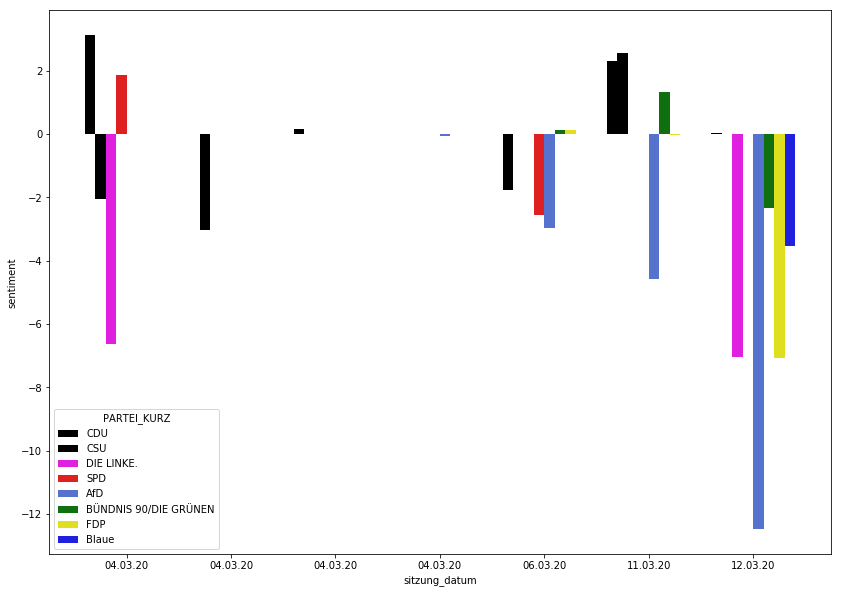

In [174]:
f, ax = plt.subplots(figsize=(14,10))
ax = sns.barplot(ax=ax, x="sitzung_datum", y="sentiment", data=d, hue = "PARTEI_KURZ", palette=color_palette_dic)
ax.set_xticklabels(d.sitzung_datum.dt.strftime('%d.%m.%y'))
ax.plot()

In [175]:
d= (df.query('maske>0')
    .groupby(['PARTEI_KURZ'])
    .agg({'sentiment':'sum'})
    .reset_index()
   )

[]

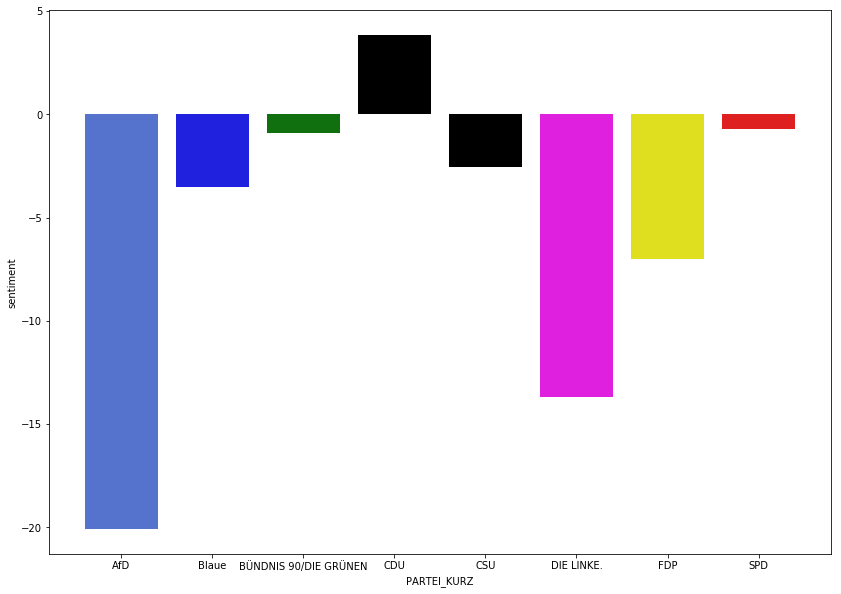

In [177]:
f, ax = plt.subplots(figsize=(14,10))
ax = sns.barplot(ax=ax, x="PARTEI_KURZ", y="sentiment", data=d, palette=color_palette_dic)
ax.plot()